<a href="https://colab.research.google.com/github/axel-sirota/tf-dev-nlp/blob/main/module5/TF_Developer_NLP_Module5_Demo1_Text_Generation_Character.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating Support like responses



Let's first import everything and load the dataset

In [1]:
!pip install textblob 'gensim==4.2.0' 'keras-nlp' swifter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 482 kB/s 
     |████████████████████████████████| 142 kB 83.1 MB/s 
     |████████████████████████████████| 830 kB 80.9 MB/s 
     |████████████████████████████████| 5.9 MB 59.6 MB/s 
     |████████████████████████████████| 280 kB 89.6 MB/s 
     |████████████████████████████████| 1.6 MB 61.6 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
     |████████████████████████████████| 4.6 MB 54.1 MB/s 
  Created wheel for swifter: filename=swifter-1.3.4-py3-none-any.whl size=16323 sha256=0f35ac4af9b38997c73f81fb60395cc61ea67a5b5832396e11bb44b21580374d
  Stored in directory: /root/.cache/pip/wheels/29/a7/0e/3a8f17ac69d759e1e93647114bc9bdc95957e5b0cbfd405205
Successfully built swifter

In [2]:
import multiprocessing
import tensorflow as tf
import sys
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda, ELU, Conv1D, MaxPooling1D, Dropout
from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras import preprocessing
from textblob import TextBlob, Word
from keras_preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Model, Input
import swifter
import keras_nlp
import numpy as np
import re
import random
import os
import pandas as pd
import gensim
import warnings
import nltk
import time

TRACE = False
embedding_dim = 256
rnn_units = 1024
epochs=20
buffer_size = 2000
# Batch size
batch_size = 256
fraction_corpus = 0.1
BATCH = True

def set_seeds_and_trace():
  os.environ['PYTHONHASHSEED'] = '0'
  np.random.seed(42)
  tf.random.set_seed(42)
  random.seed(42)
  if TRACE:
    tf.debugging.set_log_device_placement(True)

def set_session_with_gpus_and_cores():
  cores = multiprocessing.cpu_count()
  gpus = len(tf.config.list_physical_devices('GPU'))
  config = tf.compat.v1.ConfigProto( device_count = {'GPU': gpus  , 'CPU': cores} , intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(config=config) 
  K.set_session(sess)

set_seeds_and_trace()
set_session_with_gpus_and_cores()
warnings.filterwarnings('ignore')
nltk.download('punkt')
tokenizer = lambda x: TextBlob(x).words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Now we will download the dataset and explore it

In [3]:
%%writefile get_data.sh
if [ ! -f twitter.csv ]; then
  wget -O twitter.csv https://www.dropbox.com/s/hjji6x6vx4wno1c/twcs.csv?dl=0
fi

Writing get_data.sh


In [4]:
!bash get_data.sh


--2022-11-11 16:10:02--  https://www.dropbox.com/s/hjji6x6vx4wno1c/twcs.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/hjji6x6vx4wno1c/twcs.csv [following]
--2022-11-11 16:10:03--  https://www.dropbox.com/s/raw/hjji6x6vx4wno1c/twcs.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc60f2e63c3da65fc1d1f9505b1d.dl.dropboxusercontent.com/cd/0/inline/BwiriinB6VcsWTEVIleaCnf-MHrPCi35Kiz1C93zP2r0ePQCpqQg93t-t-IVUHPmOAp2i2Bv1fl6A47u1H7x9nG_ztAGO7kIwdauGc-7P3JgXjYNJ9TpjCOYUiaSJtn_P8-8oOuwGa03TZGiKOlyq4JyotCH4LRRpocPONLBEWDkPg/file# [following]
--2022-11-11 16:10:03--  https://uc60f2e63c3da65fc1d1f9505b1d.dl.dropboxusercontent.com/cd/0/inline/BwiriinB6VcsWTEVIleaCnf-MHrPCi35Kiz1C93zP2r0ePQCpqQg93t-t-IVUHPmOAp2i2Bv1fl6A47u1H7x9nG

Let's inspect how this intents csv looks like

In [5]:
! head twitter.csv

tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist you. We would need to get you into a private secured link to further assist.,2,3
2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,,1
3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messages and no one is responding as usual,1,4
4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so that we can further assist you. Just click ‘Message’ at the top of your profile.,3,5
5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6
6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,"@115712 Can you please send us a private message, so that I can gain further details about your account?","5,7",8
8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",
11,s

In [6]:
def preprocess_text(text, should_join=True):
    text = ' '.join(word.lower() for word in text.split(" "))
    text = re.sub(r"(\@\d+)", r" ", text) # remove twitter handle
    text = re.sub(r"(https\:\/\/t.co\/\w+)", r" ", text) # remove end twtter url
    text = re.sub(r"([.,!?])", r" ", text) # remove punctuation
    text = re.sub(r"[^a-zA-Z.,&!?]+", r" ", text) # only normal characters
    if should_join:
      return ' '.join(gensim.utils.simple_preprocess(text))
    else:
      return gensim.utils.simple_preprocess(text)

In [7]:
path = './twitter.csv'
twitter = pd.read_csv(path, header=0)
twitter

,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0
...,...,...,...,...,...,...,...
2811769,2987947,sprintcare,False,Wed Nov 22 08:43:51 +0000 2017,"@823869 Hey, we'd be happy to look into this f...",NaN,2987948.0
2811770,2987948,823869,True,Wed Nov 22 08:35:16 +0000 2017,@115714 wtf!? I’ve been having really shitty s...,2987947,NaN
2811771,2812240,121673,True,Thu Nov 23 04:13:07 +0000 2017,@143549 @sprintcare You have to go to https://...,NaN,2812239.0
2811772,2987949,AldiUK,False,Wed Nov 22 08:31:24 +0000 2017,"@823870 Sounds delicious, Sarah! 😋 https://t.c...",NaN,2987950.0


In [8]:
twitter[twitter.inbound == False ].author_id.value_counts()

AmazonHelp        169840
AppleSupport      106860
Uber_Support       56270
SpotifyCares       43265
Delta              42253
                   ...  
JackBox              266
OfficeSupport        218
AskDSC               210
CarlsJr              196
HotelTonightCX       152
Name: author_id, Length: 108, dtype: int64

In [9]:
twitter_filtered = twitter[twitter.inbound == False ].groupby('author_id').filter(lambda x: len(x) >= 10000).sample(frac=fraction_corpus).reset_index()
twitter_filtered.author_id.value_counts()

AmazonHelp         17248
AppleSupport       10513
Uber_Support        5651
SpotifyCares        4219
Delta               4189
Tesco               3850
AmericanAir         3585
TMobileHelp         3457
comcastcares        3313
British_Airways     2907
SouthwestAir        2904
VirginTrains        2830
Ask_Spectrum        2576
XboxSupport         2496
sprintcare          2163
hulu_support        2162
AskPlayStation      1945
ChipotleTweets      1912
GWRHelp             1904
sainsburys          1885
VerizonSupport      1849
UPSHelp             1841
ATVIAssist          1764
O2                  1671
idea_cares          1582
Safaricom_Care      1550
AskTarget           1310
BofA_Help           1297
AirAsiaSupport      1292
ArgosHelpers        1227
AskLyft             1213
SW_Help             1174
AskPayPal           1158
MicrosoftHelps      1151
marksandspencer     1144
AskAmex             1090
Morrisons           1044
Name: author_id, dtype: int64

In [10]:
responses = twitter_filtered.reset_index(drop=True).text
responses

0         @340426 Apologies! We currently don't support ...
1         @130645 Hi, please let us know if you have a s...
2         @820651 Sure Ahmed, may we have the booking nu...
3         @223341 I'm sorry to hear that you did not rec...
4         @399801 traffic through this area to keep the ...
                                ...                        
105061    @258707 Thank you for reaching out with the co...
105062    @123261 I’m disappointed to hear this and woul...
105063    @203542 Hi Annie, really sorry to hear this. C...
105064    @759927 Hey there, Anjit. We need to follow up...
105065    @483739 We understand battery life is importan...
Name: text, Length: 105066, dtype: object

In [11]:
responses[0]

"@340426 Apologies! We currently don't support off line streaming, but we'll express your interest in seeing this option in the future."

In [12]:
processed_responses = responses.swifter.apply(preprocess_text)

Pandas Apply:   0%|          | 0/105066 [00:00<?, ?it/s]

In [13]:
processed_responses[0]

'apologies we currently don support off line streaming but we ll express your interest in seeing this option in the future'

In [14]:
vocab = set()

for ix, response in processed_responses.iteritems():
    vocab.update(set(str(response)))
vocab = sorted(vocab)


In [15]:
print(f'{len(vocab)} unique characters')

27 unique characters


In [16]:

ids_from_chars = preprocessing.StringLookup(vocabulary=list(vocab), mask_token=None)


In [17]:

chars_from_ids = preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)


In [18]:

def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [19]:
ids = ids_from_chars(tf.strings.unicode_split('Only you can prevent forest fires', input_encoding='UTF-8'))
ids

<tf.Tensor: shape=(33,), dtype=int64, numpy=
array([ 0, 15, 13, 26,  1, 26, 16, 22,  1,  4,  2, 15,  1, 17, 19,  6, 23,
        6, 15, 21,  1,  7, 16, 19,  6, 20, 21,  1,  7, 10, 19,  6, 20])>

In [20]:
text_from_ids(ids)

<tf.Tensor: shape=(), dtype=string, numpy=b'[UNK]nly you can prevent forest fires'>

In [21]:
def get_maximum_review_length(srs):
    maximum = 0
    for response in srs:
        candidate = len(preprocess_text(response, should_join=True))
        if candidate > maximum:
            maximum = candidate
    return maximum


maximum = get_maximum_review_length(processed_responses)

In [22]:
maximum

278

## Creating the corpus and tokenizing

In [23]:
X_train, X_test = train_test_split(processed_responses, test_size=0.2, random_state=42)
X_train

7778      hey matthew we have more info about this here ...
79119     it was our pleasure to have you fly with us to...
54502     we love to help and explore options is your ca...
6342      need help with your console official xbox supp...
57975     please have him file report with our baggage s...
                                ...                        
54886     okay is this happening at at certain time of t...
76820     bonjour vous nous sommes navr du fait que vous...
103694    danny please accept our apologies for any inco...
860       can you please follow this link for me so can ...
15795     appreciate this must be frustrating and like t...
Name: text, Length: 84052, dtype: object

In [24]:
def pad_sequence_of_tokens(x, maxlen, unk_token='[UNK]'):
  if len(x)<maxlen:
    x.extend([unk_token]*(maxlen-len(x)))
  return x

In [25]:

def get_ids_tensor(srs):
  
  processed = srs.swifter.apply(lambda x: pad_sequence_of_tokens(list(preprocess_text(x, should_join=True)), maxlen=maximum)).to_list()
  return tf.squeeze(tf.constant(pad_sequences(ids_from_chars(processed), maxlen=maximum, padding='post'), dtype='int32'))


In [26]:
all_ids = get_ids_tensor(srs=X_train.reset_index(drop=True))
all_ids

Pandas Apply:   0%|          | 0/84052 [00:00<?, ?it/s]

<tf.Tensor: shape=(84052, 278), dtype=int32, numpy=
array([[ 9,  6, 26, ...,  0,  0,  0],
       [10, 21,  1, ...,  0,  0,  0],
       [24,  6,  1, ...,  0,  0,  0],
       ...,
       [ 5,  2, 15, ...,  0,  0,  0],
       [ 4,  2, 15, ...,  0,  0,  0],
       [ 2, 17, 17, ...,  0,  0,  0]], dtype=int32)>

In [27]:
all_ids.shape

TensorShape([84052, 278])

In [28]:
ids_from_chars(tf.strings.unicode_split(X_train.iloc[0], 'UTF-8'))


<tf.Tensor: shape=(94,), dtype=int64, numpy=
array([ 9,  6, 26,  1, 14,  2, 21, 21,  9,  6, 24,  1, 24,  6,  1,  9,  2,
       23,  6,  1, 14, 16, 19,  6,  1, 10, 15,  7, 16,  1,  2,  3, 16, 22,
       21,  1, 21,  9, 10, 20,  1,  9,  6, 19,  6,  1, 13,  6, 21,  1, 22,
       20,  1, 12, 15, 16, 24,  1, 10,  7,  1, 24,  6,  1,  4,  2, 15,  1,
        9,  6, 13, 17,  1, 24, 10, 21,  9,  1,  2, 15, 26, 21,  9, 10, 15,
        8,  1,  6, 13, 20,  6,  1, 13, 16])>

In [29]:
test_all_ids = get_ids_tensor(srs=X_test)

Pandas Apply:   0%|          | 0/21014 [00:00<?, ?it/s]

In [30]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)
test_ids_dataset = tf.data.Dataset.from_tensor_slices(test_all_ids)

In [31]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [32]:
dataset = ids_dataset.map(split_input_target)
test_dataset = test_ids_dataset.map(split_input_target)

In [33]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'hey matthew we have more info about this here let us know if we can help with anything else lo[UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][UNK][

In [34]:

shuffled_batched_dataset = (
    dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)
shuffled_batched_test_dataset = (
    test_dataset
    .shuffle(buffer_size)
    .batch(batch_size=batch_size, drop_remainder=True)
)

## Doing the train_test split and defining model

In [35]:
class RentalGenerator(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.rnn = tf.keras.layers.GRU(rnn_units,
                                   activation='tanh',
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.rnn.get_initial_state(x)
    x, states = self.rnn(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x
  
  def build_graph(self, maxlen):
    x = Input(shape=(maxlen, ))
    return Model(inputs=x, outputs=self.call(x))

In [36]:
model = RentalGenerator(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

In [37]:
for input_example_batch, target_example_batch in shuffled_batched_dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(input_example_batch.shape, "# Input: (batch_size, sequence_length)")
    print(example_batch_predictions.shape, "# Output: (batch_size, sequence_length, vocab_size)")

(256, 277) # Input: (batch_size, sequence_length)
(256, 277, 28) # Output: (batch_size, sequence_length, vocab_size)


In [38]:
model.build_graph(maxlen=maximum)  # Notice the change in outputs!

In [39]:
model.summary()

Model: "rental_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 278, 256)          7168      
                                                                 
 gru (GRU)                   [(None, 278, 1024),       3938304   
                              (None, 1024)]                      
                                                                 
 dense (Dense)               (None, 278, 28)           28700     
                                                                 
Total params: 3,974,172
Trainable params: 3,974,172
Non-trainable params: 0
_________________________________________________________________


In [40]:
perplexity = keras_nlp.metrics.Perplexity(from_logits=True, name='perplexity', mask_token_id=0)
model.compile(optimizer='adam', loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=[perplexity])


Notice the non-trainable parameters

In [41]:
history = model.fit(shuffled_batched_dataset, epochs=epochs, workers=5, validation_data=shuffled_batched_test_dataset)


Epoch 1/20
328/328 [==============================] - 23s 62ms/step - loss: 0.9223 - perplexity: 12.9546 - val_loss: 0.6804 - val_perplexity: 7.1014
Epoch 2/20
328/328 [==============================] - 20s 60ms/step - loss: 0.5761 - perplexity: 5.2611 - val_loss: 0.4893 - val_perplexity: 4.1021
Epoch 3/20
328/328 [==============================] - 20s 60ms/step - loss: 0.4376 - perplexity: 3.5291 - val_loss: 0.3958 - val_perplexity: 3.1229
Epoch 4/20
328/328 [==============================] - 20s 61ms/step - loss: 0.3699 - perplexity: 2.9043 - val_loss: 0.3478 - val_perplexity: 2.7277
Epoch 5/20
328/328 [==============================] - 20s 60ms/step - loss: 0.3321 - perplexity: 2.6054 - val_loss: 0.3193 - val_perplexity: 2.5130
Epoch 6/20
328/328 [==============================] - 20s 61ms/step - loss: 0.3076 - perplexity: 2.4287 - val_loss: 0.3007 - val_perplexity: 2.3796
Epoch 7/20
328/328 [==============================] - 20s 60ms/step - loss: 0.2904 - perplexity: 2.3116 - val_l

## Some plots

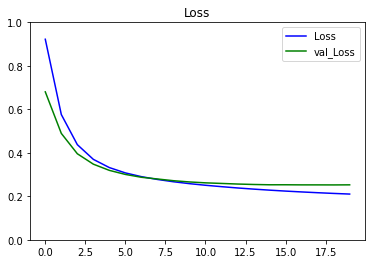

In [42]:
import matplotlib.pyplot as plt
# function for plotting loss
def plot_metrics(train_metric, val_metric=None, metric_name=None, title=None, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(train_metric,color='blue',label=metric_name)
    if val_metric is not None: plt.plot(val_metric,color='green',label='val_' + metric_name)
    plt.legend(loc="upper right")

# plot loss history
plot_metrics(history.history['loss'], history.history['val_loss'], "Loss", "Loss", ylim=1.0)


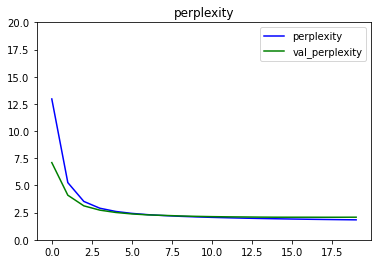

In [43]:
plot_metrics(history.history['perplexity'], val_metric=history.history['val_perplexity'], metric_name="perplexity", title="perplexity", ylim=20.0)


In [44]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [45]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
start = time.time()
states = None
next_char = tf.constant(['Hi! We are sorry'])
result = [next_char]

for n in range(250):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor([b'Hi! We are sorry carracions around little one before the being delayed state wid we putors and appear that might be announced on the next station too broken down choose homesty we look to have low for everyone we reflect watchong to our offer gt improvement would be'], shape=(1,), dtype=string) 

________________________________________________________________________________

Run time: 1.3257575035095215
